# How to plot a galaxy in Python

From [Ringermacher 2009](https://arxiv.org/pdf/0908.0892.pdf) we know that in polar coordinates, spiral galaxies shapes can be defined by the equation

$$
r = \frac{A}{\log\left( B \tan \frac{\phi}{2N} \right)}
$$

To convert from polar to cartesian coordinates we can simply do

$$
x = r \cos\phi
\\
y = r \sin\phi
$$

To rotate the arm of angle $\theta$ we can do

$$
x_1 = x \cos\theta + y \sin\theta
\\
y_1 = y \cos\theta - x \sin\theta
$$

We need to add gaussian distributed error to the stars (points) in each arm

$$
X = x + \mathcal{N}(0, \sigma_{\mathrm{arm}})
\\
Y = y + \mathcal{N}(0, \sigma_{\mathrm{arm}})
$$

where within each arm $\sigma_{\mathrm{arm}}$ increases linearly from $\sigma_{\min}$ to $\sigma_{\max}$.

We need finally to populate the nucleus

$$
\mathrm{nucleus} = \mathcal{N}(0, \sigma_{\mathrm{nucleus}})
$$

We can also add a random size to each star and randomly choose the color (white, blue, red).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats as sps
from scipy import signal
import seaborn as sns

In [2]:
def galaxy(A, B, N, size, 
           sigma_min, sigma_max, 
           nucleus_density, nucleus_sigma, 
           globular_nucleus=True,
           arms=2):
    """
    reference
    https://arxiv.org/pdf/0908.0892.pdf
    
    Max Pierini © 2021 EpiData.it
    """
    
    # phi angle
    phi = np.linspace(0, 2*np.pi, size)[1:]
    # Ringermarcher formula
    r = A / ( np.log( B * np.tan( phi / (2*N) ) ) )
    
    # convert to cartesian
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    # add gaussian error
    np.random.seed(0)
    X = x + np.random.normal(0, np.linspace(sigma_min, sigma_max, x.size), x.size)
    np.random.seed(42)
    Y = y + np.random.normal(0, np.linspace(sigma_min, sigma_max, y.size), y.size)

    # rotate and add an arm
    for i in [1]:
        # rotate
        x2 = x * np.cos(np.pi*i) + y * np.sin(np.pi*i)
        y2 = y * np.cos(np.pi*i) - x * np.sin(np.pi*i)
        # add gaussian error
        np.random.seed(41*i)
        X2 = x2 + np.random.normal(0, np.linspace(sigma_min, sigma_max, x.size), x.size)
        np.random.seed(119*i)
        Y2 = y2 + np.random.normal(0, np.linspace(sigma_min, sigma_max, y.size), y.size)
        # concatenate arms
        x = np.concatenate((x, x2))
        y = np.concatenate((y, y2))
        X = np.concatenate((X, X2))
        Y = np.concatenate((Y, Y2))
    
    if globular_nucleus:
        # gaussian distributed nucleus
        np.random.seed(1900)
        Nucleus_x = np.random.normal(0, nucleus_sigma, nucleus_density)
        np.random.seed(2000)
        Nucleus_y = np.random.normal(0, nucleus_sigma, nucleus_density)

    else:
        # gaussian linear nucleus
        nucleus_x = np.linspace(-.15, .15, nucleus_density)
        nucleus_y = np.zeros(nucleus_density)
        np.random.seed(1900)
        Nucleus_x = nucleus_x + np.random.normal(0, nucleus_sigma, nucleus_density)
        np.random.seed(2000)
        Nucleus_y = nucleus_y + np.random.normal(0, nucleus_sigma, nucleus_density)
        x = np.concatenate((x, nucleus_x))
        y = np.concatenate((y, nucleus_y))

    # concatenate arms and nucleus
    X = np.concatenate((X, Nucleus_x))
    Y = np.concatenate((Y, Nucleus_y))
    
    return x, y, X, Y, phi, r

In [3]:
def plot_galaxy(A, N, B, size,
                sigma_min, sigma_max, 
                nucleus_density, nucleus_sigma,
                globular_nucleus=True):
    # galaxy
    X, Y, x, y, phi, r = galaxy(
        A=A, N=N, B=B, size=size, 
        sigma_min=sigma_min, sigma_max=sigma_max,
        nucleus_density=nucleus_density,
        nucleus_sigma=nucleus_sigma,
        globular_nucleus=globular_nucleus,
    )

    # random sizes
    np.random.seed(1976)
    sizes = np.random.random(x.size) * 5
    # random colors
    np.random.seed(0)
    colors = np.random.choice(['w', '#ddddff', '#ffdddd'], x.size)

    # figure
    fig = plt.figure(
        constrained_layout=True,
        figsize=(7, 10)
    )
    gs = GridSpec(3, 2, figure=fig)

    # axis 1 - polar coordinates
    ax1 = fig.add_subplot(gs[0, 0], projection='polar')
    plt.polar(phi, r, 'r.', ms=1)

    # axis 2 - cartesian coordinates
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, 'k.', ms=1)
    ax2.plot(X, Y, 'r.', ms=1)
    ax2.axis('scaled')

    # axis 3 - galaxy
    ax3 = fig.add_subplot(gs[1:, 0:])

    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    # kernel density estimate
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = sps.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    # plot KDE
    ax3.imshow(np.rot90(Z), cmap='bone',
              extent=[xmin, xmax, ymin, ymax],
              aspect='auto', alpha=1
             )
    # plot stars
    ax3.scatter(x, y, s=sizes, color=colors, alpha=.5)
    # figure
    ax3.axis('scaled')
    ax3.axis('off')
    ax3.set_facecolor('k')
    # title
    fig.suptitle(
        f'Galaxy\nA{A} N{N} B{B} s{size} '
        f'$\sigma$ {sigma_min}-{sigma_max}\n'
        f'nucleus s{nucleus_density} $\sigma$ {nucleus_sigma}',
        fontsize=20
    )
    # credits
    ax3.text(
        1.01, .01,
        'Max Pierini © 2021 EpiData.it',
        rotation=90,
        transform=ax3.transAxes,
        ha='left', va='bottom'
    )
    plt.show()

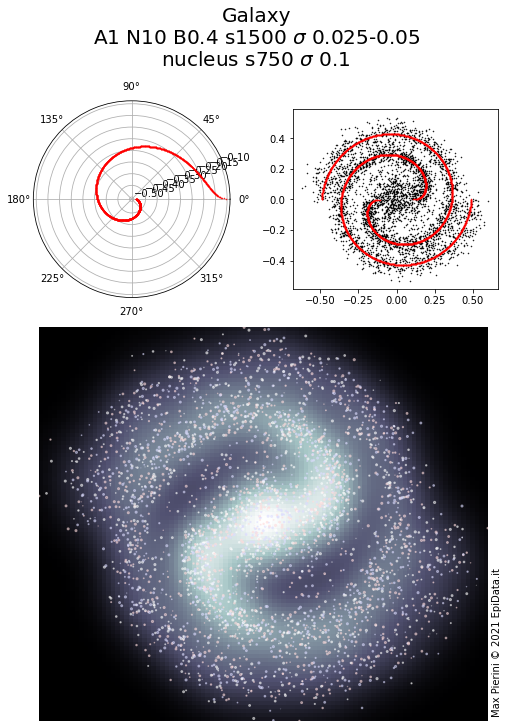

In [4]:
# galaxy parameters
A = 1
N = 10
B = .4
sigma_min = .025
sigma_max = .05
# numer of stars in each arm
size = 1500
# number of stars in nucleus
nucleus_density = 750
nucleus_sigma = .1
plot_galaxy(
    A=A, N=N, B=B, size=size, 
    sigma_min=sigma_min, sigma_max=sigma_max,
    nucleus_density=nucleus_density,
    nucleus_sigma=nucleus_sigma
)

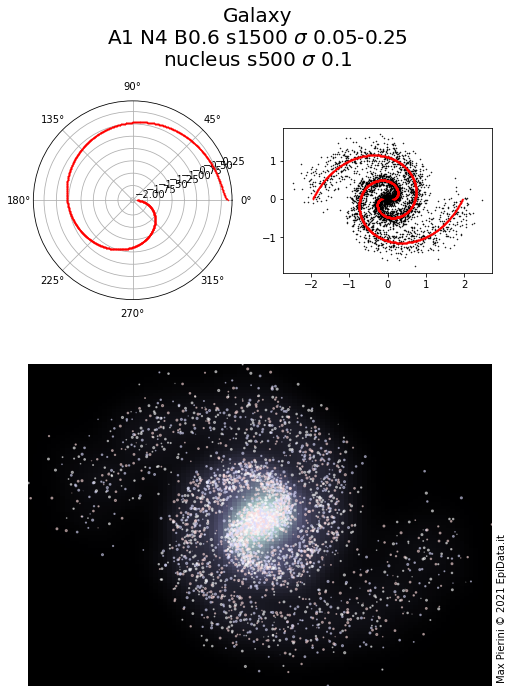

In [5]:
# galaxy parameters
A = 1
N = 4
B = .6
sigma_min = .05
sigma_max = .25
# numer of stars in each arm
size = 1500
# number of stars in nucleus
nucleus_density = 500
nucleus_sigma = .1
plot_galaxy(
    A=A, N=N, B=B, size=size, 
    sigma_min=sigma_min, sigma_max=sigma_max,
    nucleus_density=nucleus_density,
    nucleus_sigma=nucleus_sigma
)

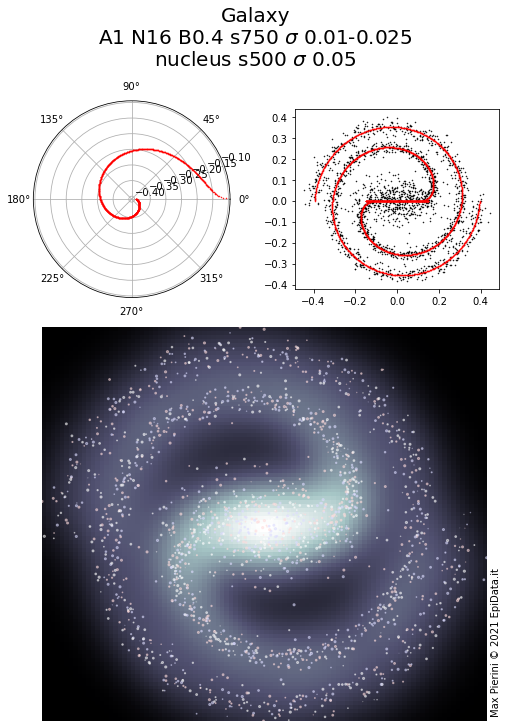

In [6]:
# galaxy parameters
A = 1
N = 16
B = .4
sigma_min = .01
sigma_max = .025
# numer of stars in each arm
size = 750
# number of stars in nucleus
nucleus_density = 500
nucleus_sigma = .05
plot_galaxy(
    A=A, N=N, B=B, size=size, 
    sigma_min=sigma_min, sigma_max=sigma_max,
    nucleus_density=nucleus_density,
    nucleus_sigma=nucleus_sigma,
    globular_nucleus=False
)

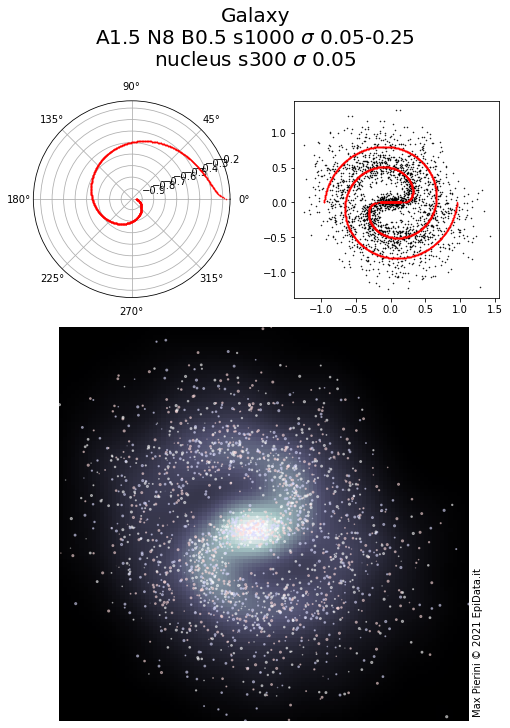

In [7]:
# galaxy parameters
A = 1.5
N = 8
B = .5
sigma_min = .05
sigma_max = .25
# numer of stars in each arm
size = 1000
# number of stars in nucleus
nucleus_density = 300
nucleus_sigma = .05
plot_galaxy(
    A=A, N=N, B=B, size=size, 
    sigma_min=sigma_min, sigma_max=sigma_max,
    nucleus_density=nucleus_density,
    nucleus_sigma=nucleus_sigma,
    globular_nucleus=False
)